# Procedural Generation of Networks
## Sigmoid Approximation

In [2]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## Functions From NB 10 For Reference

In [3]:
def odes(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations
    
    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function
        
    Returns:: Differential equations of each variable as a vector
    '''
    
    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]
    
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
    #Alpha and beta forms
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    #define each ODE
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = alpha_n*(1-n)-beta_n*n
    dmdt = alpha_m*(1-m)-beta_m*m
    dhdt = alpha_h*(1-h)-beta_h*h

    return dVdt, dndt, dmdt, dhdt

In [4]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return applied_current

In [7]:

#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

x = odeint(odes,x0,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

x0_new = x[-1,:]

#BURNED IN initial condition
vI = [5,7,0.1]
t = np.linspace(0,15,1000)
x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]


# New Code

In [12]:
#def odes_sigmoid(x0,t,I,vI):
'''
Defines the constants and differential equations for the base Hodgkin-Huxley equations

Params:: 
    x0: ICs for V,n,m,h
    t: time vector, not called in func but regardless
    I: custom function, time varying current (square wave)
    vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

Returns:: Differential equations of each variable as a vector
'''

#set ICs
V = x0[0]
n = x0[1]
m = x0[2]
h = x0[3]

#Constants
#Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
#conductances (S is Siemens)
gbarNa = 1.2 #mS/cm2
gNa = gbarNa*(m**3)*h
gbarK = 0.36 #mS/cm2
gK = gbarK*(n**4)
gbarL = 0.003 #mS/cm2
gL = gbarL

#reversal potentials
ENa = 55.17 #mV
EK = -72.14 #mV
EL = -49.42 #mV
#membrane capacitance
Cm = 0.01 #uF/cm^2

###########################################################################################

numPoints = 80
vRange = np.linspace(-80,60,numPoints)

n_inf = [0] * numPoints
m_inf = [0] * numPoints
h_inf = [0] * numPoints
n_infSIG = [0] * numPoints
m_infSIG = [0] * numPoints
h_infSIG = [0] * numPoints

tau_n = [0] * numPoints
tau_m = [0] * numPoints
tau_h = [0] * numPoints

for idx, V in enumerate(vRange):
    
    #Previous way, want to match this
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    n_inf[idx] = alpha_n / (alpha_n + beta_n)
    m_inf[idx] = alpha_m / (alpha_m + beta_m)
    h_inf[idx] = alpha_h / (alpha_h + beta_h)
    
    tau_n[idx] = 1 / (alpha_n + beta_n)
    tau_m[idx] = 1 / (alpha_m + beta_m)
    tau_h[idx] = 1 / (alpha_h + beta_h)

    #define each ODE
    #dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    #dndt = alpha_n*(1-n)-beta_n*n
    #dmdt = alpha_m*(1-m)-beta_m*m
    #dhdt = alpha_h*(1-h)-beta_h*h

    ###########################################################################################

    #New way, manipulate sigma such that it matches the above
    #V0: Manipulates the x location placement
    V0n = -50; V0m = -40; V0h = -50
    #Sigma: Manipulates the steepness, bigger sigma means less steep step
    sign = 20; sigm = 10; sigh = -10

    n_infSIG[idx] = 1 / (1 + np.exp(-(V-V0n)/sign))
    m_infSIG[idx] = 1 / (1 + np.exp(-(V-V0m)/sigm))
    h_infSIG[idx] = 1 / (1 + np.exp(-(V-V0h)/sigh))

    tau_nSIG = 10
    tau_mSIG = 10
    tau_hSIG = 10

    #define each ODE
    #dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    #dndtSIG = (1/tau_n)*(n_inf - n)
    #dmdtSIG = (1/tau_m)*(m_inf - m)
    #dhdtSIG = (1/tau_h)*(h_inf - h)

    #return dVdt, dndt, dmdt, dhdt

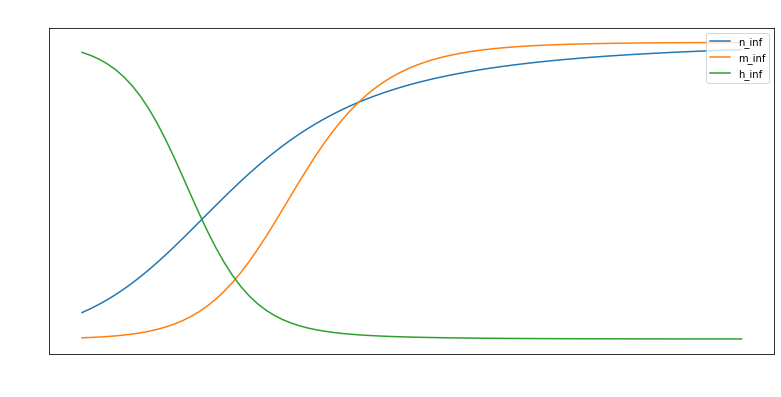

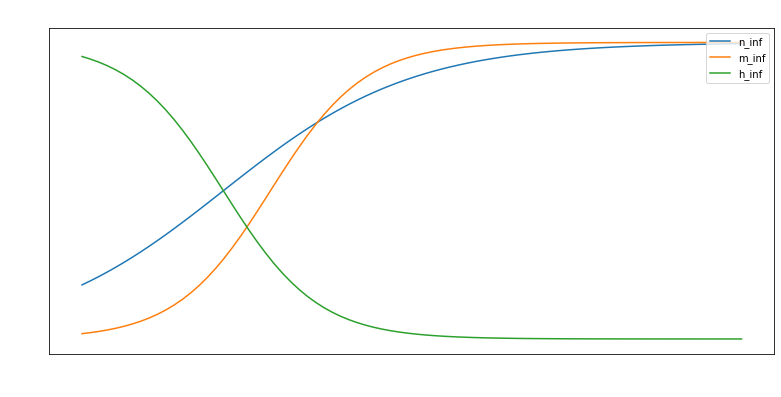

In [13]:
#Font sizes
title_font = 20
label_font = 15

plt.figure(figsize=(13,6))
plt.title("Steady State Values as a Function of Voltage", fontsize=title_font, fontweight="bold")
plt.ylabel("Steady State Value", fontsize=label_font)
plt.xlabel("Volts (mV)", fontsize=label_font)
plt.plot(vRange,n_inf,label="n_inf")
plt.plot(vRange,m_inf,label="m_inf")
plt.plot(vRange,h_inf,label="h_inf")
leg = plt.legend(loc='upper right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

plt.figure(figsize=(13,6))
plt.title("Steady State Values as a Function of Voltage", fontsize=title_font, fontweight="bold")
plt.ylabel("Steady State Value", fontsize=label_font)
plt.xlabel("Volts (mV)", fontsize=label_font)
plt.plot(vRange,n_infSIG,label="n_inf")
plt.plot(vRange,m_infSIG,label="m_inf")
plt.plot(vRange,h_infSIG,label="h_inf")
leg = plt.legend(loc='upper right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

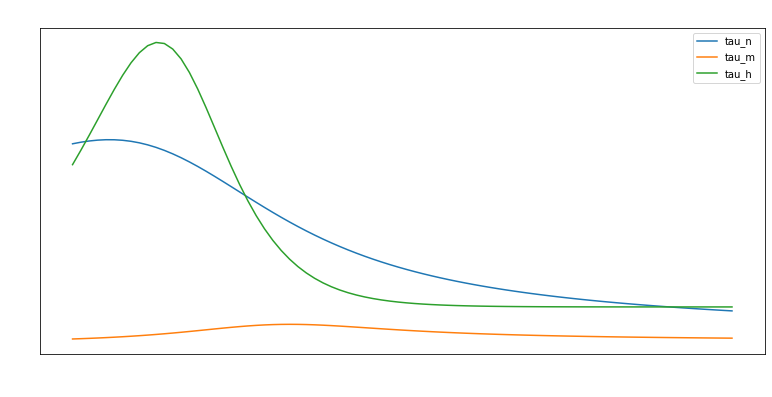

In [15]:
#Font sizes
title_font = 20
label_font = 15

plt.figure(figsize=(13,6))
plt.title("Time Constant as a Function of Voltage", fontsize=title_font, fontweight="bold")
plt.ylabel("Time Constant (ms)", fontsize=label_font)
plt.xlabel("Volts (mV)", fontsize=label_font)
plt.plot(vRange,tau_n,label="tau_n")
plt.plot(vRange,tau_m,label="tau_m")
plt.plot(vRange,tau_h,label="tau_h")
leg = plt.legend(loc='upper right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

In [ ]:
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

x = odeint(odes,x0,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

x0_new = x[-1,:]

#BURNED IN initial condition
vI = [5,7,0.1]
t = np.linspace(0,15,1000)
x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t,gatingVars=True)